In [8]:
# --- 核心库 ---
import xarray as xr
from datetime import datetime, timezone
from pathlib import Path
import numpy as np
import io

# --- 项目模块 ---
from chromasky_toolkit import config
from chromasky_toolkit.glow_index import GlowIndexCalculator
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image

# --- 辅助函数 ---
def print_mask_friendly(mask: xr.DataArray, downsample_factor: int = 4):
    """以友好的字符形式打印布尔掩码，用于直观展示。"""
    if not isinstance(mask, xr.DataArray) or mask.dtype != bool:
        print("错误：输入必须是布尔型的 xarray.DataArray。")
        return
    resampled_mask = mask.coarsen(
        latitude=downsample_factor, longitude=downsample_factor, boundary="pad"
    ).max().astype(bool)
    lat_coords, lon_coords, mask_values = resampled_mask.latitude.values, resampled_mask.longitude.values, resampled_mask.values
    print(" " * 5, end="")
    for i in range(0, len(lon_coords), 5): print(f"{lon_coords[i]:<5.1f}", end="")
    print("\n")
    for i, lat in enumerate(lat_coords):
        print(f"{lat:>4.1f} ", end="")
        for val in mask_values[i, :]: print('■' if val else '·', end="")
        print("")
    print(f"\n图例: ■ = 计算区域 (True), · = 非计算区域 (False)")
    print(f"注意: 图像已按因子 {downsample_factor} 降采样以适应显示。")

print("✅ 环境设置完毕。")

✅ 环境设置完毕。


In [ ]:
# ======================================================================
# --- 核心配置区：请在此处设置您的目标参数 ---
# ======================================================================

# 1. 设置您想分析的 UTC 日期和时间
TARGET_UTC_DATE = "2025-07-18"
TARGET_UTC_HOUR = 19  # 只需输入小时的整数

# 2. 设置您想分析的天文事件 ('sunrise' 或 'sunset')
EVENT_TYPE = "sunset"

# 3. 设置时间窗口的半径（分钟）
EVENT_WINDOW_MINUTES = 30

In [10]:

# --- 准备与计算 ---

# 1. 根据配置构建时间对象和数据路径
observation_time = datetime.fromisoformat(f"{TARGET_UTC_DATE}T{TARGET_UTC_HOUR:02d}:00:00").replace(tzinfo=timezone.utc)
data_dir = config.PROCESSED_DATA_DIR / TARGET_UTC_DATE

# 2. 加载所有需要的云数据并合并成一个 Dataset
required_vars = ['hcc', 'mcc', 'lcc']
data_arrays = {}
for var in required_vars:
    filename = f"{var}_{TARGET_UTC_HOUR:02d}00.nc"
    path = data_dir / filename
    if not path.exists():
        raise FileNotFoundError(f"必需的数据文件未找到: {path}")
    data_arrays[var] = xr.open_dataarray(path)

weather_dataset = xr.Dataset(data_arrays)
print("✅ hcc, mcc, lcc 数据加载并合并成功!")
print(weather_dataset)

# 3. 初始化计算器 (传入 Dataset)
calculator = GlowIndexCalculator(weather_data=weather_dataset)

# 4. 计算天文掩码
active_region_mask = calculator.astro_service.create_event_mask(
    weather_dataset.latitude, weather_dataset.longitude, observation_time, EVENT_TYPE, EVENT_WINDOW_MINUTES
)
print_mask_friendly(active_region_mask)

# 5. 执行网格计算 (返回 Dataset)
glow_index_dataset = calculator.calculate_for_grid(
    utc_time=observation_time,
    active_mask=active_region_mask
)
print("\n✅ 多因子火烧云指数网格计算完成!")

2025-08-07 21:33:44,111 - root - INFO - GlowIndexCalculator 初始化成功，已加载 hcc, mcc, lcc 数据。
2025-08-07 21:33:44,112 - chromasky_toolkit.astronomy - INFO - 正在为 sunset 创建时间掩码，中心时间: 11:00 UTC, 窗口: ±30分钟


✅ hcc, mcc, lcc 数据加载并合并成功!
<xarray.Dataset> Size: 684kB
Dimensions:     (latitude: 217, longitude: 261)
Coordinates:
    number      int64 8B 0
    valid_time  datetime64[ns] 8B 2025-07-04T11:00:00
  * latitude    (latitude) float64 2kB 54.0 53.75 53.5 53.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 2kB 70.0 70.25 70.5 ... 134.5 134.8 135.0
    expver      <U4 16B '0005'
Data variables:
    hcc         (latitude, longitude) float32 227kB ...
    mcc         (latitude, longitude) float32 227kB ...
    lcc         (latitude, longitude) float32 227kB ...


Calculating sunset times:   0%|          | 0/56637 [00:00<?, ?it/s]

2025-08-07 21:33:45,737 - root - INFO - 开始为网格活动区域计算多因子火烧云指数...


     70.4 75.4 80.4 85.4 90.4 95.4 100.4105.4110.4115.4120.4125.4130.4135.0

53.6 ··································································
52.6 ··································································
51.6 ·······························································■■■
50.6 ······························································■■■■
49.6 ·····························································■■■■■
48.6 ····························································■■■■■■
47.6 ··························································■■■■■■■■
46.6 ·························································■■■■■■■■■
45.6 ························································■■■■■■■■■■
44.6 ·······················································■■■■■■■■■■■
43.6 ······················································■■■■■■■■■■■■
42.6 ·····················································■■■■■■■■■■■■■
41.6 ·····················································■

Calculating Multi-Factor Glow Index:   0%|          | 0/11043 [00:00<?, ?it/s]

2025-08-07 21:36:40,797 - root - INFO - 多因子网格计算完成。



✅ 多因子火烧云指数网格计算完成!


2025-08-07 21:36:40,816 - MapDrawer - INFO - --- [绘图] 开始生成地图: 多因子火烧云指数预报 (Final Score)
预报时间: 2025-07-04 11:00 UTC ---
2025-08-07 21:36:41,111 - MapDrawer - INFO - 正在绘制活动区域掩码轮廓...
2025-08-07 21:36:42,463 - MapDrawer - INFO - --- [绘图] 地图已成功保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\src\outputs\maps\glow_index\glow_index_20250704_1100.png ---



✅ 地图已成功生成并保存到: C:\Users\zhang\Documents\Code\chromasky-toolkit\src\outputs\maps\glow_index\glow_index_20250704_1100.png
正在下方显示地图...


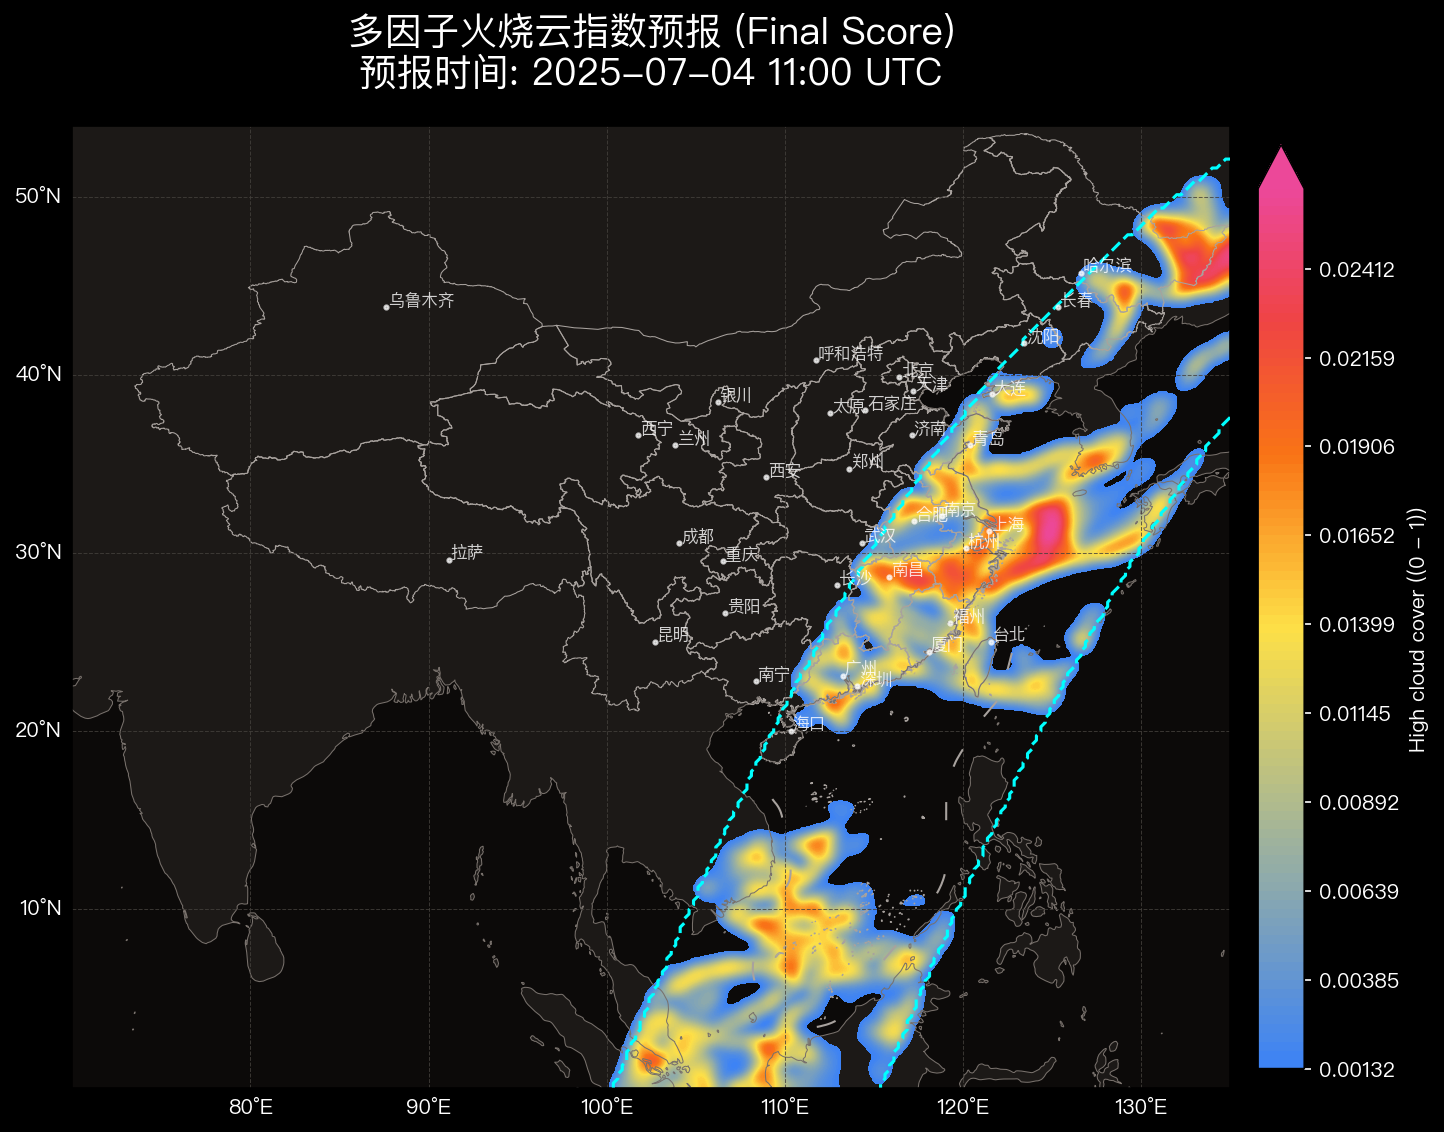

In [11]:
# --- 6. 调用绘图函数生成地图 ---

# 从返回的 Dataset 中选择最终得分进行绘图
final_score_grid = glow_index_dataset['final_score']

map_title = (
    f"多因子火烧云指数预报 (Final Score)\n"
    f"预报时间: {observation_time.strftime('%Y-%m-%d %H:%M UTC')}"
)

output_dir = config.MAP_OUTPUTS_DIR / "glow_index"
output_dir.mkdir(parents=True, exist_ok=True)
map_output_path = output_dir / f"glow_index_{observation_time.strftime('%Y%m%d_%H%M')}.png"

image_bytes = generate_map_from_grid(
    score_grid=final_score_grid,
    title=map_title,
    output_path=map_output_path,
    active_region_mask=active_region_mask
)

# --- 7. 在 Notebook 中显示生成的地图 ---
if image_bytes:
    print(f"\n✅ 地图已成功生成并保存到: {map_output_path}")
    print("正在下方显示地图...")
    display(Image(data=image_bytes, width=800))
else:
    print("\n❌ 地图生成失败。")